Sử dụng thuật toán di truyền để tìm trọng số cho mạng nơ ron tế bào cho bài toán tìm biên ảnh.
Một số lưu ý trong quá trình code:
- Do hàm giải phương trình vi phân (ODE) chỉ nhận mảng 1 chiều (array) vào giá trị ban đầu cũng như đầu ra của x nên phải biến đổi từ dạng ma trận về mảng 1 chiều ở một số phép tính.
- Thứ tự của m, n (kích thước của ma trận đầu vào) đôi khi bị ngược nhau trong quá trình reshape. Lưu ý khi đưa vào ma trận không vuông.
- Các số dùng trong phép tính nên để ở dạng float

In [1]:
from scipy.signal import convolve2d
from scipy.integrate import ode
from PIL import Image as img
import numpy as np
import numpy.matlib as mat
import math

In [3]:
# hàm trạng thái
def hamTrangThai(t, x, u, B, A, I, n, m):
    x = x.reshape(n, m)
    dx = -x + convolve2d(u, B, 'same') + convolve2d(hamDauRa(x), A, 'same') + I
    return dx.reshape(n*m)

# hàm đầu ra
def hamDauRa(x):
    return 0.5 * (abs(x + 1) - abs(x - 1))

# Tạo ma trận đối xứng từ 5 trọng số (hàm này chỉ dành riêng cho ma trận đối xứng 3x3)
def taoMaTranDoiXung(arr1):#giả sử cho mảng [1,2,3,4,5]
    arr2 = arr1[-2::-1].copy()#tạo mảng phụ [4,3,2,1]
    arr2[0], arr2[2] = arr2[2], arr2[0]#nếu không có lệnh này thì ma trận tạo ra sẽ bị ngược
    return np.append(arr1,arr2).reshape(h,h)#kết hợp hai mảng rồi chuyển về dạng ma trận 3x3

# Hàm lai hai số
def lai(a,b):#k là điểm lai  -3,|45
    if(a>0):
        return math.modf(a)[1]+abs(math.modf(b)[0])
    return math.modf(a)[1]-abs(math.modf(b)[0])

# Hàm tạo số ngẫu nhiên từ -9.99 đến 9.99
def ngauNhien():
    return np.random.randint(-999,1000)/100.

# Hàm tính sai số
def saiSo(d,y):
    return np.sum(0.5*(d-y)**2)

# Bán kính lân cận của nơ ron tế bào
r = 1

# kích thước của ma trận điều khiển và ma trận phản hồi (hai ma trận này luôn vuông)
h = 2*r + 1 # h = 3

class CNN:
    # Quần thể trọng số (gồm 11 số)
    quanThe = np.array([ngauNhien() for i in range(11)])

    # kích thước ma trận đầu vào, ma trận đầu ra và ma trận trạng thái
    m, n = 5, 5

    # ma trận ảnh đầu vào u
    u = np.array([
        [ 1, 1, 1, 1,-1],
        [ 1, 1, 1, 1,-1],
        [ 1, 1, 1, 1, 1],
        [ 1, 1, 1, 1, 1],
        [-1,-1, 1, 1, 1]], dtype=float)

    # ma trận đầu ra mong muốn d
    d = np.array([
        [ 1, 1, 1, 1,-1],
        [ 1,-1,-1, 1,-1],
        [ 1,-1,-1,-1, 1],
        [ 1, 1,-1,-1, 1],
        [-1,-1, 1, 1, 1]], dtype=float)

    # ma trận điều khiển B ban đầu
    # B = np.array([
    #     [-1.,-1.,-1.],
    #     [-1., 8.,-1.],
    #     [-1.,-1.,-1.]])
    B = taoMaTranDoiXung(quanThe[:5])

    # ma trận phản hồi A ban đầu
    # A = np.array([
    #     [ 0., 0., 0.],
    #     [ 0., 1., 0.],
    #     [ 0., 0., 0.]])
    A = taoMaTranDoiXung(quanThe[5:10])

    # mức ngưỡng I ban đầu
    I = quanThe[10]
    #I = -1.0

    # hai giá trị ban đầu cho ptvp gồm x0 = [ma trận toàn số 0] với t0 = 0.0 và t1 để tính đầu ra x1 (t1 != t0)
    x0, t0, t1 = u*0.0, 0.0, 0.5

    # ma trận đầu ra y (y được tính theo x)
    y = hamDauRa(x0)

    # sai số cho phép
    E0 = 2.0

    # sai số hiện tại
    E = float('inf')

cnn = CNN()

# Hàm tối ưu trọng số thứ i trong quần thể
def toiUuTrongSo(i, soChaMe):
    tapChaMe = [[ngauNhien(),ngauNhien()] for i in range(soChaMe)]
    for chaMe in tapChaMe:
        con = lai(chaMe[0],chaMe[1])
        quanTheMoi = cnn.quanThe.copy()
        quanTheMoi[i] = con
        ACon = taoMaTranDoiXung(quanTheMoi[:5])
        BCon = taoMaTranDoiXung(quanTheMoi[5:10])
        ICon = quanTheMoi[10]
        ptvp.set_initial_value(cnn.x0.flatten(), 0.0)
        ptvp.set_f_params(cnn.u, BCon, ACon, ICon, cnn.n, cnn.m)
        xCon = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
        yCon = hamDauRa(xCon)
        yCon = np.sign(yCon)
        ECon = saiSo(cnn.d,yCon)
        if(ECon <= cnn.E):
            cnn.y = yCon.copy()
            #cnn.u = xCon.copy()
            cnn.quanThe = quanTheMoi.copy()
            cnn.E = ECon
            cnn.A = ACon.copy()
            cnn.B = BCon.copy()
            cnn.I = ICon

# khởi tạo phương trình vi phân
ptvp = ode(hamTrangThai) 
ptvp.set_integrator('vode') # thuật toán được sử dụng để giải ptvp, đọc thêm trong tài liệu
ptvp.set_initial_value(cnn.x0.flatten(), 0.0) # lệnh flatten dùng để biến đổi ma trận về dạng mảng (đầu vào của ode phải là một số hoặc mảng)

print(f'A = {cnn.A}')
print(f'B = {cnn.B}')
print(f'u = {cnn.u}')
print(f'd = {cnn.d}')

ptvp.set_f_params(cnn.u, cnn.B, cnn.A, cnn.I, cnn.n, cnn.m)
assert ptvp.successful()
x = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
y = hamDauRa(x)
y = np.sign(y)
print(f'y = {y}')
print(f'E = {saiSo(cnn.d,y)}')

A = [[ 9.64  3.9   8.09]
 [ 9.27 -5.4   3.9 ]
 [ 8.09  9.27  9.64]]
B = [[ 8.75  3.11 -1.35]
 [ 8.45 -3.34  3.11]
 [-1.35  8.45  8.75]]
u = [[ 1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [-1. -1.  1.  1.  1.]]
d = [[ 1.  1.  1.  1. -1.]
 [ 1. -1. -1.  1. -1.]
 [ 1. -1. -1. -1.  1.]
 [ 1.  1. -1. -1.  1.]
 [-1. -1.  1.  1.  1.]]
y = [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
E = 22.0


In [4]:
print('Bộ trọng số ban đầu: ')
print(f'A = {cnn.A}')
print(f'B = {cnn.B}')
print(f'I = {cnn.I}')
# thuật toán tối ưu từng trọng số theo phương pháp ngẫu nhiên
soChaMe = 200 # số cha mẹ được chọn để lai mới mỗi trọng số 
loop = 2000 #số lần chạy thử tối đa
count = 0 # đếm số lần chạy
while(True):
    # kiểm tra ptvp ODE
    if(not ptvp.successful()):
        print('Lỗi phương trình vi phân')
        break

    # đếm số lần chạy
    count+=1
    if(count>loop):
        print('Đạt đến số vòng lặp tối đa')
        break
    else:
        print(f'Lần chạy thứ {count}')

    # xét trọng số
    ts = count%11 # STT trọng số hiện tại đang được lai (trọng số lai)
    #print(f'xét trọng số thứ {tsl} trong quần thể')
    toiUuTrongSo(ts, soChaMe)

    print(f'y = {cnn.y}')
    print(f'E = {cnn.E}')
    #print(f'A = {cnn.A}')

    # kiểm tra sai số
    if(cnn.E <= cnn.E0):
        print('Đạt đến mức sai số cho phép')
        break

print('Bộ trọng sau khi tối ưu: ')
print(f'A = {cnn.A}')
print(f'B = {cnn.B}')
print(f'I = {cnn.I}')

Bộ trọng số ban đầu: 
A = [[ 9.64  3.9   8.09]
 [ 9.27 -5.4   3.9 ]
 [ 8.09  9.27  9.64]]
B = [[ 8.75  3.11 -1.35]
 [ 8.45 -3.34  3.11]
 [-1.35  8.45  8.75]]
I = 8.28
Lần chạy thứ 1
y = [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
E = 22.0
Lần chạy thứ 2
y = [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
E = 22.0
Lần chạy thứ 3
y = [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
E = 22.0
Lần chạy thứ 4
y = [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
E = 22.0
Lần chạy thứ 5
y = [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
E = 22.0
Lần chạy thứ 6
y = [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
E = 22.0
Lần chạy thứ 7
y = [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
E = 22.0


In [28]:
# Lưu lại bộ trọng số
np.savetxt('A.txt',cnn.A)
np.savetxt('B.txt',cnn.B)
np.savetxt('I.txt',np.array([cnn.I]))
print('Đã lưu')

Đã lưu


In [32]:
# kiểm tra lại bộ trọng số

testA = np.loadtxt('A.txt')
testB = np.loadtxt('B.txt')
testI = np.loadtxt('I.txt')
print(f'A = {testA}')
print(f'B = {testB}')
print(f'I = {testI}')
ptvp.set_initial_value(cnn.x0.flatten(), 0.0)
ptvp.set_f_params(cnn.u, testB, testA, testI, cnn.n, cnn.m)
x = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
y = hamDauRa(x)
y = np.sign(y)
print('y = ')
print(y)
print(f'sai số: {saiSo(cnn.d,y)}')

A = [[ 7.28  0.71  1.39]
 [-1.18  8.52  0.71]
 [ 1.39 -1.18  7.28]]
B = [[-9.12 -0.41  0.99]
 [-0.57  8.79 -0.41]
 [ 0.99 -0.57 -9.12]]
I = 6.05
y = 
[[ 1.  1.  1.  1. -1.]
 [ 1. -1. -1.  1. -1.]
 [ 1. -1. -1. -1.  1.]
 [ 1.  1. -1. -1.  1.]
 [-1. -1.  1.  1.  1.]]
sai số: 0.0


y = [[255. 255. 255. ... 255. 255. 255.]
 [255.   0.   0. ...   0. 255. 255.]
 [255.   0.   0. ...   0.   0. 255.]
 ...
 [255. 255.   0. ...   0.   0. 255.]
 [255. 255. 255. ...   0.   0. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
done


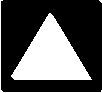

In [33]:
#test với ảnh cụ thể

from PIL import Image as img

maTranAnh = img.open('images/input5.png').convert('RGB')
m,n = maTranAnh.size
u = np.array(maTranAnh)[:,:,0]
u = u/255.0*2.0-1.0
ptvp.set_initial_value((u*0.0).flatten(), 0.0)
ptvp.set_f_params(u, testB, testA, testI, n, m)
x = (ptvp.integrate(cnn.t1))[:].reshape(n, m)
y = hamDauRa(x)
y = np.sign(y)
y = (y/2.0+0.5)*255
print(f'y = {y}')
out = img.fromarray(y).convert('RGB')
out.save('images/output5.png')
print('done')
out